# Histograms of docking scores

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from time import time
import numpy as np
import pandas as pd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
print(Path.cwd())

os.sys.path.append('../src')
from utils.utils import load_data, get_print_func, cast_to_float
from utils.resample import flatten_dist

/vol/ml/apartin/projects/covid-19/ML-docking-dataframe-generator/nbs


In [2]:
def plot_hist_dock_scores(df, subdir_name, scoring_func='Chemgauss4'):
    """ ... """
    outfigs_dir = outfigs/subdir_name
    os.makedirs(outfigs_dir, exist_ok=True)
    fig, ax = plt.subplots()
    ax.hist(df[score_name], bins=100, facecolor='b', alpha=0.7);
    ax.set_xlabel(f'Docking Score ({scoring_func})')
    ax.set_ylabel('Count')
    plt.grid(True)
    plt.title(f'{subdir_name}; Samples {len(df)}')
    plt.tight_layout()
    plt.savefig(outfigs_dir/f'dock.dist.{trg_name}.png')

In [3]:
datadir = Path('/vol/ml/apartin/projects/covid-19/ML-docking-dataframe-generator/data/raw/docking/V5.1/OZD')
files = sorted(datadir.glob('*.sorted.4col.csv'))
print(len(files))

outfigs = Path('../paper')
os.makedirs(outfigs, exist_ok=True)

35


In [4]:
# Load: All, Raw
dpath = files[0]
dock = pd.read_csv(dpath)
print(dock.shape)
display(dock[:2])

(6109329, 4)


,Inchi-key,SMILES,TITLE,Chemgauss4
0,MQQAVNHQRUNOBV-SDHOMARFSA-P,Cc1ccc(cc1)[C@@H]2C[N@@H+]([C@@H]3[C@H]2N4CCC3...,ZINC000095370606,-15.272850
1,DGLCKPUNCXSIDP-UHFFFAOYSA-P,c1ccc(cc1)N2CC[NH+](CC2)C/C(=[NH+]/OCC(=O)NCc3...,ZINC000040149497,-14.439569


In [5]:
score_name = 'reg'
ID = 'TITLE'
trg_name = dpath.name

scoring_func = 'Chemgauss4'
dock = dock.rename(columns={scoring_func: score_name})  # note! Chemgauss4 might be different
dock = dock[ dock[ID].notna() ].reset_index(drop=True)  # drop TITLE==nan
dock[score_name] = dock[score_name].map(lambda x: cast_to_float(x) )  # cast scores to float
dock = dock[ dock[score_name].notna() ].reset_index(drop=True)  # drop non-float

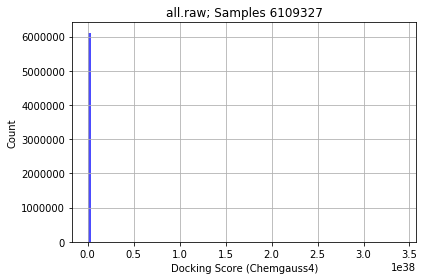

In [6]:
plot_hist_dock_scores(dock, subdir_name='all.raw', scoring_func='Chemgauss4')

In [7]:
# Convert and bound scores to >=0
dock[score_name] = abs( np.clip(dock[score_name], a_min=None, a_max=0) )

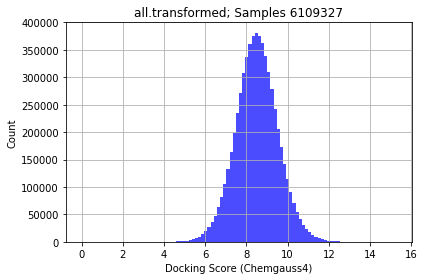

In [8]:
plot_hist_dock_scores(dock, subdir_name='all.transformed', scoring_func=scoring_func)

In [24]:
# ----------------------------------
#    Sampling
# ----------------------------------
# Sample the scores
# n_samples = 100000  # 100K
n_samples = 1000000  # 1M
n_top = 10000
# flatten = True
flatten = False

In [25]:
n_bot = n_samples - n_top

aa = dock.copy()
aa = aa.sort_values('reg', ascending=False).reset_index(drop=True)
df_top = aa[:n_top].reset_index(drop=True)  # e.g. 100K
df_rest = aa[n_top:].reset_index(drop=True)

print(df_top.shape)
print(df_rest.shape)

(10000, 4)
(6099327, 4)


In [26]:
if flatten:
    df_bot = flatten_dist(df=df_rest, n=n_bot, score_name=score_name)
else:
    df_bot = df_rest.sample(n=n_bot, replace=False)

In [27]:
assert df_top.shape[1] == df_bot.shape[1], 'Num cols must be the same when concat.'
aa = pd.concat([df_top, df_bot], axis=0).reset_index(drop=True)

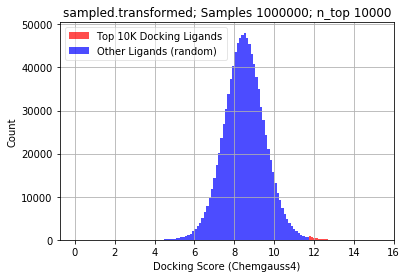

In [28]:
# Plot histogram of sampled scores
flatten_str = 'flatten' if flatten else 'random'
n_samples_str = '100K' if n_samples == 100000 else '1M'
outfigs_dir = outfigs/f'sampled.transformed.{n_samples_str}.{flatten_str}'

os.makedirs(outfigs_dir, exist_ok=True)
fig, ax = plt.subplots()
ax.hist(df_top[score_name], bins=100, facecolor='r', alpha=0.7, label='Top 10K Docking Ligands');
ax.hist(df_bot[score_name], bins=100, facecolor='b', alpha=0.7, label=f'Other Ligands ({flatten_str})');
ax.set_xlabel(f'Docking Score ({scoring_func})')
ax.set_ylabel('Count')
plt.grid(True)
plt.legend(loc='best', framealpha=0.5)
plt.title(f'sampled.transformed; Samples {n_samples}; n_top {n_top}')
plt.savefig(outfigs_dir/f'dock.dist.{trg_name}.png', dpi=150)